In [1]:
!pip install evaluate
!pip install --upgrade torch transformers

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import json
import glob
import itertools
from PIL import Image

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
import pandas as pd

class BioDataset(torch.utils.data.Dataset):
    def __init__(self, rna_path, mult_path, cell_type_path, is_train):
        self.rna = []
        self.shared = []
        self.mult = []
        self.cell_type = []

        atac_data = pd.read_csv(rna_path, index_col=0)
        mult_data = pd.read_csv(mult_path, index_col=0)
        cell_type = pd.read_csv(cell_type_path, index_col=0)


        # Transpose atac and mult
        atac_data = atac_data.T
        mult_data = mult_data.T

        # Drop the first row
        atac_data = atac_data.iloc[1:]
        mult_data = mult_data.iloc[1:]

        # Join cell_type's broad_celltype to atac_data and mult_data
        atac_data = atac_data.join(cell_type)
        mult_data = mult_data.join(cell_type)

        print(atac_data)

        atac_cell_types = []
        mult_data_cell_types = []

        # Get the broad_celltype column from atac_data and mult_data
        for i in range(len(atac_data)):
            atac_cell_types.append(atac_data.iloc[i]["broad_celltype"])

        for i in range(len(mult_data)):
            mult_data_cell_types.append(mult_data.iloc[i]["broad_celltype"])

        if is_train:
          self.cell_type = atac_cell_types
        else:
          self.cell_type = mult_data_cell_types
        # Print lenght of unique values in cell_type
        print(len(set(self.cell_type)))

        # Drop all cell_type columns from atac_data and mult_data
        atac_data = atac_data.drop(columns=cell_type.columns)
        mult_data = mult_data.drop(columns=cell_type.columns)

        # Convert values to float
        atac_data = atac_data.astype(float)
        mult_data = mult_data.astype(float)

        # Find column names that are shared between atac and mul
        colNames = atac_data.columns.intersection(mult_data.columns)

        # Create colNames only in atac and only in mult
        colNames_atac = atac_data.columns.difference(mult_data.columns)
        colNames_mult = mult_data.columns.difference(atac_data.columns)

        print(len(colNames))
        print(len(colNames_atac))
        print(len(colNames_mult))

        if is_train:
          # Loop through atac_data
          for i in range(len(atac_data)):
              # Add values in atac_data that are not in colNames to rna
              rna_values = atac_data.iloc[i][~atac_data.columns.isin(colNames)].tolist()
              self.rna.append(rna_values)

              # Add values in atac_data that are in colNames to shared
              shared_values = atac_data.iloc[i][atac_data.columns.isin(colNames)].tolist()
              self.shared.append(shared_values)

              # Create values of length colNames_mult and add to mult
              mult_values = [-1998] * len(colNames_mult)
              self.mult.append(mult_values)
        else:
          # Loop through mult_data
          for i in range(len(mult_data)):
              # Add values in mult_data that are not in colNames to mult
              mult_values = mult_data.iloc[i][~mult_data.columns.isin(colNames)].tolist()
              self.mult.append(mult_values)

              # Add values in mult_data that are in colNames to shared
              shared_values = mult_data.iloc[i][mult_data.columns.isin(colNames)].tolist()
              self.shared.append(shared_values)

              # Create values of length colNames_atac and add to rna
              rna_values = [-1998] * len(colNames_atac)
              self.rna.append(rna_values)


        # Check that rna shared mult and cellType have same length
        assert len(self.rna) == len(self.shared)
        assert len(self.rna) == len(self.mult)
        assert len(self.rna) == len(self.cell_type)

        self._check_for_nan()

    def _check_for_nan(self):
        for i in range(len(self.rna)):
            if (np.isnan(self.rna[i]).any() or
                np.isnan(self.shared[i]).any() or
                np.isnan(self.mult[i]).any()):
                raise ValueError(f"NaN value found at index {i}")


    def __len__(self):
        return len(self.rna)

    def __getitem__(self, idx):
        return {
            "rna": self.rna[idx],
            "shared": self.shared[idx],
            "atac": self.mult[idx],
            "cell_type": self.cell_type[idx]
        }

In [4]:
def collate_fn(batch):
    # Separate the different components of the batch
    rna = [item['rna'] for item in batch]
    shared = [item['shared'] for item in batch]
    atac = [item['atac'] for item in batch]
    cell_types = [item['cell_type'] for item in batch]

    if len(rna[0]) == 0:
      rna = [[-1998] * 25] * len(rna)
    if len(shared[0]) == 0:
      shared = [[-1998] * 25] * len(shared)
    if len(atac[0]) == 0:
      atac = [[-1998] * 25] * len(atac)

    # Convert rna, shared, and atac to tensors of float values
    # Use float32 for better performance, or float64 for higher precision if needed
    rna_tensor = torch.tensor(rna, dtype=torch.float32)
    shared_tensor = torch.tensor(shared, dtype=torch.float32)
    atac_tensor = torch.tensor(atac, dtype=torch.float32)

    # Create attention masks
    # We still use > 0 for the mask, which works for both positive and negative floats
    rna_mask = (rna_tensor != -1998).bool()
    shared_mask = (shared_tensor != -1998).bool()
    atac_mask = (atac_tensor != -1998).bool()

    # Return a dictionary with the tensors, attention masks, and cell types
    return {
        'rna': rna_tensor,
        'rna_attention_mask': rna_mask,
        'shared': shared_tensor,
        'shared_attention_mask': shared_mask,
        'atac': atac_tensor,
        'atac_attention_mask': atac_mask,
        'cell_type': cell_types
    }

In [5]:
# Create the train/eval/test datasets
dataset = BioDataset('/content/cleaned_RNA.csv', '/content/cleaned_Multiome.csv', '/content/cleaned_colData.csv', True)
test_dataset = BioDataset('/content/cleaned_RNA.csv', '/content/cleaned_Multiome.csv', '/content/cleaned_colData.csv', False)
# eval_dataset = BioDataset('./data/dev.jsonl')
# test_dataset = HatefulMemesDataset('./data/test.jsonl', './data')

                  CA6      CNR2    IFNLR1     RCAN3    ZNF683     CSF3R  \
AAACAGCCAATGCGCT  0.0  0.000000  0.000000  2.183987  0.000000  0.000000   
AAACAGCCAGTTTACG  0.0  0.000000  0.000000  1.064252  0.000000  0.000000   
AAACAGCCATCCAGGT  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
AAACATGCAAGGTCCT  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
AAACATGCACTTGTTC  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
...               ...       ...       ...       ...       ...       ...   
TTTGTGGCAGCAACCT  0.0  0.000000  0.000000  0.000000  0.000000  2.091534   
TTTGTGTTCAATTACG  0.0  0.000000  0.000000  0.000000  1.706397  0.000000   
TTTGTGTTCATTGACA  0.0  0.000000  0.000000  0.000000  0.000000  2.527060   
TTTGTGTTCGATAACC  0.0  1.191013  0.000000  0.000000  0.000000  0.000000   
TTTGTGTTCTCCATAT  0.0  0.000000  0.784946  0.000000  0.000000  1.960553   

                     SCMH1    HIVEP3  ZSWIM5  SHISAL2A  ...  KLHL13     TENM1  \
AAACAGCCAATGCGCT  

In [6]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

rna_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
multi_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

In [7]:
import torch

def compute_jaccard_similarity(embeddings_omics1, embeddings_omics2, k=100):
    """
    Computes differentiable Jaccard similarity between nearest neighbors in two omics layers.

    Args:
        embeddings_omics1 (torch.Tensor): Embeddings for omics layer 1 (e.g., RNA).
        embeddings_omics2 (torch.Tensor): Embeddings for omics layer 2 (e.g., chromatin).
        k (int): Number of nearest neighbors to consider (default is 100).

    Returns:
        torch.Tensor: Mean Jaccard similarity across all cells.
    """
    num_cells_omics1 = embeddings_omics1.shape[0]
    num_cells_omics2 = embeddings_omics2.shape[0]

    # Combine embeddings
    combined_embeddings = torch.cat([embeddings_omics1, embeddings_omics2])

    # Compute pairwise distances
    distances = torch.cdist(combined_embeddings, combined_embeddings)

    # Get top k nearest neighbors for each cell
    _, neighbors = torch.topk(distances, k=k, largest=False, dim=1)

    jaccard_similarities = []

    for i in range(num_cells_omics1 + num_cells_omics2):
        # Create binary tensors for set representation
        set_omics1 = torch.zeros(num_cells_omics1 + num_cells_omics2, device=embeddings_omics1.device)
        set_omics2 = torch.zeros(num_cells_omics1 + num_cells_omics2, device=embeddings_omics1.device)

        # Fill in the sets based on the neighbors
        set_omics1[neighbors[i]] = 1
        set_omics2[neighbors[i]] = 1

        # Adjust sets based on which omics layer the cell belongs to
        if i < num_cells_omics1:
            set_omics1[num_cells_omics1:] = 0
        else:
            set_omics2[:num_cells_omics1] = 0

        # Compute intersection and union
        intersection = torch.min(set_omics1, set_omics2).sum()
        union = torch.max(set_omics1, set_omics2).sum()

        # Compute Jaccard similarity
        jaccard_similarity = intersection / (union + 1e-8)  # Add small epsilon to avoid division by zero
        jaccard_similarities.append(jaccard_similarity)

    # Return the mean Jaccard similarity
    return torch.stack(jaccard_similarities).mean()

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        batch_size = features.shape[0]
        similarity_matrix = F.cosine_similarity(features.unsqueeze(1), features.unsqueeze(0), dim=2)

        # Create a mask for positive pairs
        mask = (labels.unsqueeze(1) == labels.unsqueeze(0)).float()
        mask = mask - torch.eye(batch_size, device=features.device)

        positives = similarity_matrix[mask.bool()].view(batch_size, -1)
        negatives = similarity_matrix[~mask.bool()].view(batch_size, -1)

        logits = torch.cat([positives, negatives], dim=1) / self.temperature
        labels = torch.zeros(batch_size, device=features.device, dtype=torch.long)

        loss = F.cross_entropy(logits, labels)
        return loss


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoderLayer, TransformerEncoder
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import gc
from sklearn.metrics import jaccard_score
from sklearn.neighbors import NearestNeighbors
from torch.nn import CrossEntropyLoss
import torch.nn.init as init

if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda")
else:
    print("GPU is not available, using CPU")
    device = torch.device("cpu")

def print_most_frequent_percentage(tensor):
    """Prints the percentage of values in a tensor that are the same as the most frequent value."""

    # Find the most frequent value
    unique_values, counts = torch.unique(tensor, return_counts=True)
    most_frequent_value = unique_values[torch.argmax(counts)]

    # Calculate the percentage
    percentage = (torch.sum(tensor == most_frequent_value) / tensor.nelement()) * 100

    print(f"Percentage of values equal to {most_frequent_value}: {percentage:.2f}%")


class MultimodalTransformerClassifier(nn.Module):
    def __init__(self, hidden_dim, num_heads, num_layers, embedding_size, dropout=0.3):
        super().__init__()

        for batch in train_loader:
            break

        def calculate_out_features(in_features):
            out_features = in_features // 5  # Divide by 10
            out_features = (out_features // 5) * 5  # Round down to the nearest multiple of 10
            # If out_features is 0 after rounding, set it to 10
            # out_features = 10 if out_features == 0 else out_features
            return out_features

        self.rna_out_features = calculate_out_features(batch["rna"].shape[1])
        self.shared_out_features = calculate_out_features(batch["shared"].shape[1])
        self.atac_out_features = calculate_out_features(batch["atac"].shape[1])

        self.original_rna_out_features = batch["rna"].shape[1]
        self.original_shared_out_features = batch["shared"].shape[1]
        self.original_atac_out_features = batch["atac"].shape[1]

        self.rna_encoder = TransformerEncoder(TransformerEncoderLayer(d_model=1, nhead=1, dropout=dropout, batch_first=True), num_layers=num_layers)
        self.shared_encoder = TransformerEncoder(TransformerEncoderLayer(d_model=1, nhead=1, dropout=dropout, batch_first=True), num_layers=num_layers)
        self.atac_encoder = TransformerEncoder(TransformerEncoderLayer(d_model=1, nhead=1, dropout=dropout, batch_first=True), num_layers=num_layers)

        self.rna_embedding = nn.Linear(batch["rna"].shape[1], batch["rna"].shape[1] * hidden_dim, bias=True)
        init.xavier_uniform_(self.rna_embedding.weight) # or any other desired initialization

        self.shared_embedding = nn.Linear(batch["shared"].shape[1], batch["shared"].shape[1] * hidden_dim, bias=True)
        init.xavier_uniform_(self.shared_embedding.weight) # or any other desired initialization

        self.atac_embedding = nn.Linear(batch["atac"].shape[1], batch["atac"].shape[1] * hidden_dim, bias=True)
        init.xavier_uniform_(self.atac_embedding.weight) # or any other desired initialization

        encoder_layer = TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Linear(hidden_dim, embedding_size)
        init.xavier_uniform_(self.classifier.weight) # or any other desired initialization

        self.dropout = nn.Dropout(dropout)
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim

    def forward(self, rna, rna_mask, shared, shared_mask, atac, atac_mask):
        rna = rna.to(device)
        rna_mask = rna_mask.to(device)
        shared = shared.to(device)
        shared_mask = shared_mask.to(device)
        atac = atac.to(device)
        atac_mask = atac_mask.to(device)

        rna = rna.unsqueeze(-1)
        shared = shared.unsqueeze(-1)
        atac = atac.unsqueeze(-1)

        # print_most_frequent_percentage(shared)

        rna = (rna - rna.mean(dim=1, keepdim=True)) / (rna.std(dim=1, keepdim=True) + 1e-8)
        shared = (shared - shared.mean(dim=1, keepdim=True)) / (shared.std(dim=1, keepdim=True) + 1e-8)
        atac = (atac - atac.mean(dim=1, keepdim=True)) / (atac.std(dim=1, keepdim=True) + 1e-8)

        # rna = self.rna_encoder(rna, src_key_padding_mask=~rna_mask.bool())
        # shared = self.shared_encoder(shared, src_key_padding_mask=~shared_mask.bool())
        # atac = self.atac_encoder(atac, src_key_padding_mask=~atac_mask.bool())

        # Multiply shared by the mask
        rna = rna * rna_mask.unsqueeze(-1)
        shared = shared * shared_mask.unsqueeze(-1)
        atac = atac * atac_mask.unsqueeze(-1)

        rna = rna.squeeze(-1)
        shared = shared.squeeze(-1)
        atac = atac.squeeze(-1)

        # Embed each modality
        rna_emb = self.rna_embedding(rna)
        shared_emb = self.shared_embedding(shared)
        atac_emb = self.atac_embedding(atac)

        # print_most_frequent_percentage(shared)

        rna_emb = rna_emb.view(rna.shape[0], self.original_rna_out_features, self.hidden_dim)
        shared_emb = shared_emb.view(shared.shape[0], self.original_shared_out_features, self.hidden_dim)
        atac_emb = atac_emb.view(atac.shape[0], self.original_atac_out_features, self.hidden_dim)

        # Concatenate embeddings
        x = torch.cat([rna_emb, shared_emb, atac_emb], dim=1)
        # x = shared_emb

        # Concatenate attention masks
        mask = torch.cat([rna_mask, shared_mask, atac_mask], dim=1)
        # mask = shared_mask

        # x = self.transformer_encoder(x, src_key_padding_mask=~mask.bool())
        x = self.transformer_encoder(x)
        # x = x.unsqueeze(-1)

        # Global average pooling
        # x = x * mask.unsqueeze(-1)
        x = x.sum(dim=1) / mask.sum(dim=1, keepdim=True)

        # Apply classifier
        # x = self.dropout(x)
        # print(x.shape)
        logits = self.classifier(x)

        return logits

def soft_nearest_neighbor_loss(embeddings, labels, temperature=1.0, num_neighbors=32):
    batch_size, embedding_dim = embeddings.shape

    # Convert string labels to numerical format
    unique_labels = set(labels)
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    numerical_labels = torch.tensor([label_to_index[label] for label in labels], device=embeddings.device)

    # Compute pairwise distances
    pairwise_distances = torch.cdist(embeddings, embeddings)

    # Mask out self-distances
    mask = torch.eye(batch_size, device=embeddings.device)
    masked_distances = pairwise_distances + mask * 1e9

    # Get the k nearest neighbors
    _, indices = torch.topk(masked_distances, k=num_neighbors, largest=False)

    # Get labels of nearest neighbors
    neighbor_labels = numerical_labels[indices]

    # Calculate similarity scores
    similarity = torch.exp(-pairwise_distances / temperature)

    # Mask out self-similarity
    similarity = similarity * (1 - mask)

    # Calculate probabilities
    probs = similarity / similarity.sum(dim=1, keepdim=True)

    # Calculate loss
    same_label_mask = (neighbor_labels == numerical_labels.unsqueeze(1))
    neighbor_probs = torch.gather(probs, 1, indices)
    loss = -torch.log(torch.sum(neighbor_probs * same_label_mask.float(), dim=1) + 1e-8).mean()

    return loss

# Example usage
hidden_dim = 6
num_heads = 2
num_layers = 4
embedding_size = 2

model = MultimodalTransformerClassifier(hidden_dim, num_heads, num_layers, embedding_size)
model = model.to(device)

# Hyperparameters
num_epochs = 10
learning_rate = 1e-4
jaccard_weight = 0.5  # Weight for Jaccard similarity in the loss function

# In your training loop
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = CrossEntropyLoss()
# criterion_contrast = ContrastiveLoss(temperature=0.5)


# Function to compute accuracy using KNN
def compute_knn_accuracy(train_logits, train_labels, test_logits, test_labels, k=5):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_logits, train_labels)
    predictions = knn.predict(test_logits)
    return accuracy_score(test_labels, predictions)

train_loss = []
test_loss = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    num_batches = len(train_loader)
    train_logits_list = []
    train_labels_list = []

    # Use tqdm for progress bar
    with tqdm(total=num_batches, desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for batch_idx, batch in enumerate(train_loader):
            optimizer.zero_grad()

            rna = batch['rna']
            rna_mask = batch['rna_attention_mask']
            shared = batch['shared']
            shared_mask = batch['shared_attention_mask']
            atac = batch['atac']
            atac_mask = batch['atac_attention_mask']
            cell_types = batch['cell_type']

            logits = model(rna, rna_mask, shared, shared_mask, atac, atac_mask)

            # Convert string labels to numerical format
            unique_labels = list(set(cell_types))
            label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
            numerical_labels = torch.tensor([label_to_index[label] for label in cell_types], device=device)

            # Compute cross-entropy loss
            loss = criterion(logits, numerical_labels)
            # loss = criterion_contrast(logits, numerical_labels)
            # Get rna_embeddings and multi embeddings using indexes of numerical_labels and logits
            # rna_embeddings = logits[numerical_labels]
            # multi_embeddings = logits[numerical_labels]

            # loss = loss_func(rna_embeddings, multi_embeddings)

            # # Backpropagate and update weights
            # loss.backward()

            # # Compute soft nearest neighbor loss
            # snn_loss = soft_nearest_neighbor_loss(logits, cell_types, temperature=0.1, num_neighbors=5)

            # # Move logits off of the gpu
            logits = logits.detach().cpu().numpy()

            # # Compute Jaccard similarity
            # rna_embeddings = model(rna, rna_mask, shared, shared_mask, torch.zeros_like(atac), torch.zeros_like(atac_mask))
            # atac_embeddings = model(torch.zeros_like(rna), torch.zeros_like(rna_mask), shared, shared_mask, atac, atac_mask)
            # jaccard_sim = compute_jaccard_similarity(rna_embeddings, atac_embeddings, rna.shape[0])
            # rna_embeddings = rna_embeddings.detach().cpu().numpy()
            # atac_embeddings = atac_embeddings.detach().cpu().numpy()


            # # Combine losses
            # loss = snn_loss - jaccard_weight * jaccard_sim  # Subtract because we want to maximize Jaccard similarity
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Store logits and labels for KNN
            train_logits_list.append(logits)
            train_labels_list.extend(cell_types)

            # Update progress bar
            pbar.update(1)
            pbar.set_postfix({'loss': f"{loss.item():.4f}"})

    # Calculate and print average loss for the epoch
    avg_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{num_epochs} completed. Average Loss: {avg_loss:.4f}")
    train_loss.append(avg_loss)

    # Compute and report training accuracy
    train_logits = np.concatenate(train_logits_list)
    train_labels = np.array(train_labels_list)
    train_accuracy = compute_knn_accuracy(train_logits, train_labels, train_logits, train_labels)
    print(f"Training Accuracy: {train_accuracy:.4f}")

    # Evaluate on test set
    model.eval()
    test_logits_list = []
    test_labels_list = []
    rna_embeddings_list = []
    multi_embeddings_list = []
    total_loss = 0
    num_batches = len(test_loader)

    with torch.no_grad():
        # Get RNA embeddings
        for batch in rna_loader:
            rna = batch['rna']
            rna_mask = batch['rna_attention_mask']
            shared = batch['shared']
            shared_mask = batch['shared_attention_mask']
            atac = batch['atac']  # Placeholder for atac in RNA data
            atac_mask = batch['atac_attention_mask']  # Placeholder for atac mask

            embeddings = model(rna, rna_mask, shared, shared_mask, atac, atac_mask)
            rna_embeddings_list.append(embeddings.cpu().numpy())

        # Get Multiome embeddings
        for batch in multi_loader:
            rna = batch['rna']  # Placeholder for rna in Multiome data
            rna_mask = batch['rna_attention_mask']  # Placeholder for rna mask
            shared = batch['shared']
            shared_mask = batch['shared_attention_mask']
            atac = batch['atac']
            atac_mask = batch['atac_attention_mask']

            embeddings = model(rna, rna_mask, shared, shared_mask, atac, atac_mask)
            multi_embeddings_list.append(embeddings.cpu().numpy())

        for batch in test_loader:
            rna = batch['rna']
            rna_mask = batch['rna_attention_mask']
            shared = batch['shared']
            shared_mask = batch['shared_attention_mask']
            atac = batch['atac']
            atac_mask = batch['atac_attention_mask']
            cell_types = batch['cell_type']

            logits = model(rna, rna_mask, shared, shared_mask, atac, atac_mask)

            unique_labels = list(set(cell_types))
            label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
            numerical_labels = torch.tensor([label_to_index[label] for label in cell_types], device=device)

            # Compute cross-entropy loss
            loss = criterion(logits, numerical_labels)
            total_loss += loss.item()

            test_logits_list.append(logits.cpu().numpy())
            test_labels_list.extend(cell_types)

    test_logits = np.concatenate(test_logits_list)
    test_labels = np.array(test_labels_list)

    # Compute and report test accuracy
    test_accuracy = compute_knn_accuracy(train_logits, train_labels, test_logits, test_labels)

    # Concatenate embeddings
    rna_embeddings = np.concatenate(rna_embeddings_list)
    multi_embeddings = np.concatenate(multi_embeddings_list)

    # Convert rna_embeddings and mult_embeddings to torch tensors
    rna_embeddings = torch.tensor(rna_embeddings, dtype=torch.float32)
    multi_embeddings = torch.tensor(multi_embeddings, dtype=torch.float32)

    # Compute and report Jaccard similarity
    test_jaccard = compute_jaccard_similarity(rna_embeddings, multi_embeddings)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Jaccard Similarity: {test_jaccard:.4f}")
    test_loss.append(total_loss / num_batches)

print("Training completed!")

GPU is available


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
Epoch 1/10: 100%|██████████| 158/158 [00:23<00:00,  6.75it/s, loss=0.0015]


Epoch 1/10 completed. Average Loss: 0.0383
Training Accuracy: 0.9964
Test Accuracy: 0.9857
Test Jaccard Similarity: 0.9998


Epoch 2/10: 100%|██████████| 158/158 [00:22<00:00,  6.98it/s, loss=0.0018]


Epoch 2/10 completed. Average Loss: 0.0019
Training Accuracy: 0.9998
Test Accuracy: 0.9978
Test Jaccard Similarity: 0.9986


Epoch 3/10: 100%|██████████| 158/158 [00:22<00:00,  6.97it/s, loss=0.0006]


Epoch 3/10 completed. Average Loss: 0.0009
Training Accuracy: 1.0000
Test Accuracy: 0.9998
Test Jaccard Similarity: 0.9999


Epoch 4/10: 100%|██████████| 158/158 [00:22<00:00,  6.98it/s, loss=0.0004]


Epoch 4/10 completed. Average Loss: 0.0005
Training Accuracy: 1.0000
Test Accuracy: 0.9998
Test Jaccard Similarity: 0.9999


Epoch 5/10: 100%|██████████| 158/158 [00:22<00:00,  6.98it/s, loss=0.0004]


Epoch 5/10 completed. Average Loss: 0.0004
Training Accuracy: 1.0000
Test Accuracy: 0.9998
Test Jaccard Similarity: 0.9999


Epoch 6/10: 100%|██████████| 158/158 [00:22<00:00,  6.97it/s, loss=0.0003]


Epoch 6/10 completed. Average Loss: 0.0004
Training Accuracy: 1.0000
Test Accuracy: 0.9998
Test Jaccard Similarity: 0.9999


Epoch 7/10: 100%|██████████| 158/158 [00:22<00:00,  6.99it/s, loss=0.0003]


Epoch 7/10 completed. Average Loss: 0.0003
Training Accuracy: 1.0000
Test Accuracy: 0.9998
Test Jaccard Similarity: 1.0000


Epoch 8/10: 100%|██████████| 158/158 [00:22<00:00,  6.98it/s, loss=0.0003]


Epoch 8/10 completed. Average Loss: 0.0003
Training Accuracy: 1.0000
Test Accuracy: 0.9998
Test Jaccard Similarity: 1.0000


Epoch 9/10: 100%|██████████| 158/158 [00:22<00:00,  6.98it/s, loss=0.0002]


Epoch 9/10 completed. Average Loss: 0.0003
Training Accuracy: 1.0000
Test Accuracy: 1.0000
Test Jaccard Similarity: 1.0000


Epoch 10/10: 100%|██████████| 158/158 [00:22<00:00,  7.00it/s, loss=0.0003]


Epoch 10/10 completed. Average Loss: 0.0002
Training Accuracy: 1.0000
Test Accuracy: 0.9998
Test Jaccard Similarity: 1.0000
Training completed!


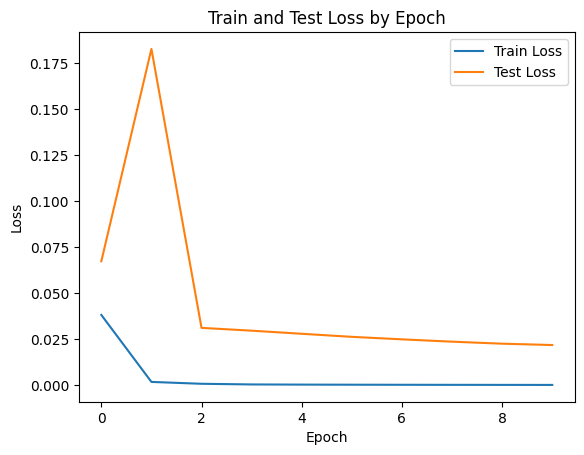

In [10]:
# prompt: Graph train and test loss by epoch

import matplotlib.pyplot as plt

# Assuming train_loss and test_loss lists are populated in your training loop
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss by Epoch')
plt.legend()
plt.show()

In [11]:
# prompt: Print total number of parameters in model

def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 9,359,014 trainable parameters


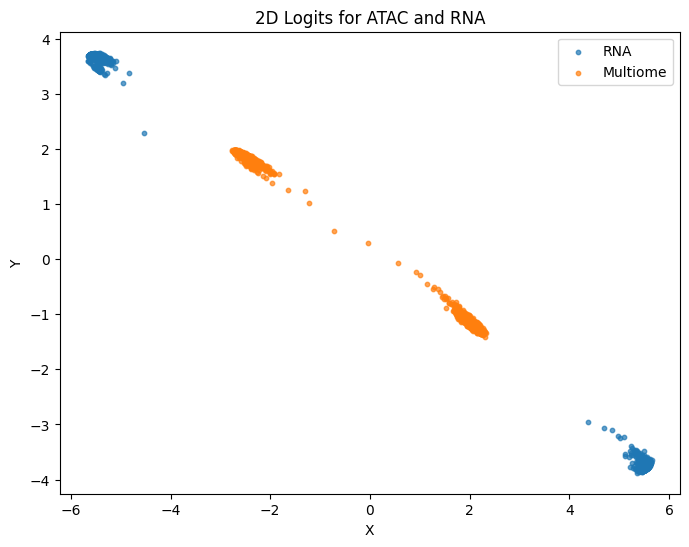

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'rna_embeddings' and 'multi_embeddings' are available from the training loop
# and are numpy arrays of shape (num_samples, embedding_dim)

# Reduce dimensionality for plotting (e.g., using PCA or t-SNE if embedding_dim > 2)
# If embedding_dim is already 2, skip this step.

# Example using PCA (you'll need to install scikit-learn: !pip install scikit-learn)
from sklearn.decomposition import PCA

rna_embeddings_2d = rna_embeddings
multi_embeddings_2d = multi_embeddings
if rna_embeddings.shape[1] > 2:
  pca = PCA(n_components=2)
  rna_embeddings_2d = pca.fit_transform(rna_embeddings)
  multi_embeddings_2d = pca.transform(multi_embeddings)

# Create the plot
plt.figure(figsize=(8, 6))

# Plot RNA embeddings
plt.scatter(rna_embeddings_2d[:, 0], rna_embeddings_2d[:, 1], label='RNA', alpha=0.7, s=10)

# Plot Multiome embeddings
plt.scatter(multi_embeddings_2d[:, 0], multi_embeddings_2d[:, 1], label='Multiome', alpha=0.7, s=10)


# Add labels, title and legend
plt.xlabel("X")
plt.ylabel("Y")
plt.title("2D Logits for ATAC and RNA")
plt.legend()

# Show the plot
plt.show()

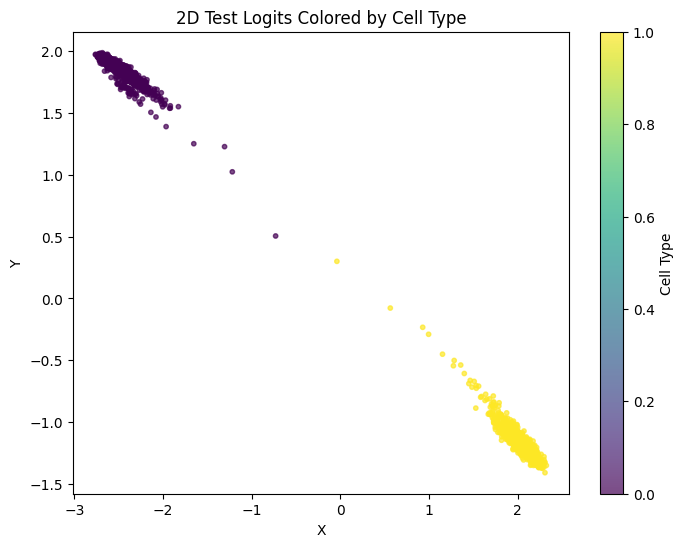

In [13]:
from sklearn.preprocessing import LabelEncoder

# Assuming 'test_logits' and 'test_labels' are available from the training loop
# and are numpy arrays of shape (num_samples, embedding_dim) and (num_samples,) respectively.

# Reduce dimensionality for plotting if needed (e.g., using PCA)
test_logits_2d = test_logits
if test_logits.shape[1] > 2:
    pca = PCA(n_components=2)
    test_logits_2d = pca.fit_transform(test_logits)

# Convert string labels to numerical labels
label_encoder = LabelEncoder()
numerical_labels = label_encoder.fit_transform(test_labels)

# Create the plot
plt.figure(figsize=(8, 6))

# Use numerical labels for coloring the points
scatter = plt.scatter(test_logits_2d[:, 0], test_logits_2d[:, 1], c=numerical_labels, cmap='viridis', alpha=0.7, s=10)

# Add colorbar to show the mapping between colors and labels
plt.colorbar(scatter, label='Cell Type')


# Add labels, title and legend
plt.xlabel("X")
plt.ylabel("Y")
plt.title("2D Test Logits Colored by Cell Type")


# Show the plot
plt.show()

In [14]:
# def compute_jaccard_similarity(embeddings_omics1, embeddings_omics2, k=100):
#     """
#     Computes Jaccard similarity between nearest neighbors in two omics layers.

#     Args:
#         embeddings_omics1 (np.array): Embeddings for omics layer 1 (e.g., RNA).
#         embeddings_omics2 (np.array): Embeddings for omics layer 2 (e.g., chromatin).
#         k (int): Number of nearest neighbors to consider (default is 100).

#     Returns:
#         float: Mean Jaccard similarity across all cells.
#     """

#     num_cells_omics1 = embeddings_omics1.shape[0]
#     num_cells_omics2 = embeddings_omics2.shape[0]

#     # 1. Assign unique cell IDs
    # cell_ids_omics1 = np.arange(num_cells_omics1)
    # cell_ids_omics2 = np.arange(num_cells_omics2)

    # # 2. Perform NearestNeighbors on combined embeddings
    # combined_embeddings = np.concatenate([embeddings_omics1, embeddings_omics2])
    # nn = NearestNeighbors(n_neighbors=k, metric='euclidean')
    # nn.fit(combined_embeddings)

    # _, neighbors_omics1 = nn.kneighbors(embeddings_omics1)
    # _, neighbors_omics2 = nn.kneighbors(embeddings_omics2)

    # jaccard_similarities = []

    # # 3. Calculate Jaccard similarity for each cell
    # for i in range(num_cells_omics1):
    #     # Get neighbor cell IDs for omics1 and omics2
    #     neighbor_ids_omics1 = [cell_ids_omics1[x] if x < num_cells_omics1 else -1 for x in neighbors_omics1[i]]
    #     neighbor_ids_omics2 = [-1 if x < num_cells_omics1 else cell_ids_omics2[x - num_cells_omics1] for x in neighbors_omics1[i]]

    #     # Convert to sets
    #     set_neighbors_omics1 = set(neighbor_ids_omics1)
    #     set_neighbors_omics2 = set(neighbor_ids_omics2)
    #     if -1 in set_neighbors_omics1:
    #         set_neighbors_omics1.remove(-1)
    #     if -1 in set_neighbors_omics2:
    #         set_neighbors_omics2.remove(-1)

    #     # Compute intersection and union
    #     intersection = len(set_neighbors_omics1.intersection(set_neighbors_omics2))
    #     union = len(set_neighbors_omics1.union(set_neighbors_omics2))

    #     # Compute Jaccard similarity
    #     jaccard_similarity = intersection / union if union else 0.0
    #     jaccard_similarities.append(jaccard_similarity)

    # for i in range(num_cells_omics2):
    #     # Get neighbor cell IDs for omics1 and omics2
    #     neighbor_ids_omics1 = [cell_ids_omics1[x] if x < num_cells_omics1 else -1 for x in neighbors_omics2[i]]
    #     neighbor_ids_omics2 = [-1 if x < num_cells_omics1 else cell_ids_omics2[x - num_cells_omics1] for x in neighbors_omics2[i]]

    #     # Convert to sets
    #     set_neighbors_omics1 = set(neighbor_ids_omics1)
    #     set_neighbors_omics2 = set(neighbor_ids_omics2)
    #     if -1 in set_neighbors_omics1:
    #         set_neighbors_omics1.remove(-1)
    #     if -1 in set_neighbors_omics2:
    #         set_neighbors_omics2.remove(-1)

        # Compute intersection and union
    #     intersection = len(set_neighbors_omics1.intersection(set_neighbors_omics2))
    #     union = len(set_neighbors_omics1.union(set_neighbors_omics2))

    #     # Compute Jaccard similarity
    #     jaccard_similarity = intersection / union if union else 0.0
    #     jaccard_similarities.append(jaccard_similarity)


    # # 4. Return the mean Jaccard similarity
    # return np.mean(jaccard_similarities)


In [15]:
# prompt: split train_dataset into unpaired and paired data (paired data is data which is shared within rna and atac_seq use the unpaired data as a train_set and the paired data as a validation set

import random

# Assuming train_dataset is your BioDataset object
# and it has some form of indexing or splitting capability

# Define the split ratio (e.g., 80% for training, 20% for validation)
split_ratio = 0.8
dataset_size = len(dataset)
split_index = int(dataset_size * split_ratio)

# Create indices for the split
indices = list(range(dataset_size))
random.shuffle(indices)  # Shuffle for random splitting
train_indices = indices[:split_index]
val_indices = indices[split_index:]


# Create Subset objects for train and validation sets
from torch.utils.data import Subset

unpaired_train_dataset = Subset(dataset, train_indices)
paired_val_dataset = Subset(dataset, val_indices) # Using a portion of the train data as paired validation

# - unpaired_train_dataset:  Data for training (unpaired)
# - paired_val_dataset: Data for validation (paired)


# Example usage with DataLoaders (assuming you have defined batch_size)
batch_size = 32

train_loader = torch.utils.data.DataLoader(
    unpaired_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn # Use your collate function
)

val_loader = torch.utils.data.DataLoader(
    paired_val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn # Use your collate function
)

print(f"Train dataset size: {len(unpaired_train_dataset)}")
print(f"Validation dataset size: {len(paired_val_dataset)}")



Train dataset size: 4038
Validation dataset size: 1010


In [16]:
import torch

def calculate_foscttm_loss(true_matches, distances):
    """
    Calculates the Fraction of Samples Closer Than the True Match (FOSCTTM) loss.

    Parameters:
        true_matches (torch.Tensor): Indices of true matches in the `distances` tensor for each query.
                                      Shape: (n_queries,)
        distances (torch.Tensor): Pairwise distance tensor of shape (n_queries, n_samples).

    Returns:
        torch.Tensor: The FOSCTTM loss value (lower is better).
    """
    n_queries = distances.shape[0]
    # Initialize a tensor of zeros with requires_grad=True
    # Use .clone() to create a new tensor that does not share storage with the original
    foscttm_values = torch.zeros(n_queries, device=distances.device, requires_grad=True).clone()

    for i in range(n_queries):
        true_match_index = true_matches[i]
        true_match_distance = distances[i, true_match_index]
        closer_count = torch.sum(distances[i] < true_match_distance)
        # Calculate the FOSCTTM value and detach it before assigning
        foscttm_value = closer_count.detach() / (distances.shape[1] - 1)
        foscttm_values[i] = foscttm_value # Assign the detached value

    # Calculate and return the mean FOSCTTM loss
    return foscttm_values.mean()

def loss_func(rna_embeddings, multi_embeddings):
    """
    Calculates the loss based on FOSCTTM.

    Parameters:
        rna_embeddings (torch.Tensor): Embeddings for RNA data.
        multi_embeddings (torch.Tensor): Embeddings for Multiome data.

    Returns:
        torch.Tensor: The FOSCTTM loss value.
    """
    # Calculate pairwise distances between embeddings
    distances = torch.cdist(rna_embeddings, multi_embeddings)

    # Get indices of true matches (assuming one-to-one correspondence)
    # You might need to modify this part based on your specific data structure
    true_matches = torch.arange(rna_embeddings.shape[0], device=rna_embeddings.device)

    # Calculate FOSCTTM loss
    loss = calculate_foscttm_loss(true_matches, distances)

    return loss